# Spatial Analysis: The Influence of Infrastructure on Crime Incidents 


### Get Crime Data 

Crime data for last 5 years (2019 - 2024) used from [Queensland Police Services](https://www.data.qld.gov.au/dataset/crime-locations-2000-present) The QPS API supports getting relevant geographical data (i.e. police stations, police-related boundaries, suburbs and local government area) and offence data by [ABS meshblocks](https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026). 



In [1]:
# Uncomment to install geopandas
!pip install geopandas

DEPRECATION: Loading egg at /opt/conda/lib/python3.11/site-packages/tflite_model_maker-0.3.4-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 34.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 16.5 MB/s eta 0:00:00


# Step 1: Prepare Data for the Analysis

## 1.1 Get the details of crime incidents


In [28]:
# Connect to QPS REST API for offences? using Python requests library
import requests, json
import pandas

# Set the URL for the REST API for offences
off_url = "https://a5c7zwf7e5.execute-api.ap-southeast-2.amazonaws.com/dev/offences?"

# Query string parameters
startDate = "10-15-2019"
endDate =   "10-15-2024"
locationType = "SUBURB"
locationName = "Chermside"
format = "JSON"

# Build the URL for the REST API
off_query = off_url + "locationType="+locationType + "&locationName="+locationName + \
            "&startDate="+startDate + "&endDate="+endDate + "&format="+format 

# Send the request to the REST API  
response = requests.get(off_query)

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()
    off_df = pandas.json_normalize(data)
    
else:
    print('Get location request failed')

In [29]:
off_df

,Type,Date,Postcode,Area of Interest,ABS Meshblock
0,Unlawful Entry,2019-10-25 08:00:00,4032,Chermside,30052240000
1,Unlawful Use of Motor Vehicle,2019-10-25 08:00:00,4032,Chermside,30052240000
2,Unlawful Entry,2019-10-25 09:00:00,4032,Chermside,30052260000
3,Other Theft (excl. Unlawful Entry),2019-10-25 10:30:00,4032,Chermside,30052940000
4,Other Theft (excl. Unlawful Entry),2019-10-25 13:06:00,4032,Chermside,30052420000
...,...,...,...,...,...
13040,Other Theft (excl. Unlawful Entry),2024-10-15 17:20:00,4032,Chermside,30563248200
13041,Other Property Damage,2024-10-15 17:22:00,4032,Chermside,30052420000
13042,Unlawful Use of Motor Vehicle,2024-10-15 20:00:00,4032,Chermside,30052940000
13043,Drug Offences,2024-10-15 21:30:00,4032,Chermside,30052570000


Acccording to above values we can see highest number of incidents recorded under other theft category. My goal is to find where are these incidents happen?

In [30]:
# To check the data is only for targetted Suburb
off_df['Area of Interest'].unique()

array(['Chermside'], dtype=object)

## 1.1.1 Get the mesh block details of the Target Suburb

In [31]:
# Connect to QPS REST API for location? using Python requests library
import requests
import json
import geopandas

# Set the URL for the REST API for locations
loc_url = "https://a5c7zwf7e5.execute-api.ap-southeast-2.amazonaws.com/dev/locations?"

# Query string parameters
locationType = "SUBURB"
locationName = "Chermside"
format = "JSON"

# Build the URL for the REST API
loc_query = loc_url + "locationType=" + locationType + "&locationName=" + locationName + "&format=" + format

# Send the request to the REST API  
response = requests.get(loc_query)

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()
    # print(json.dumps(response.json()))   # print JSON response
    # Convert json to a dataframe
    sub_df = geopandas.GeoDataFrame.from_features(data[0],crs="EPSG:4326")
else:
    print('Get location request failed')

In [32]:
sub_df

,geometry,Name,Type
0,"POLYGON ((153.02 -27.374, 153.02 -27.374, 153....",Chermside,Suburb
1,"POLYGON ((153.01 -27.375, 153 -27.375, 153 -27...",Chermside West,Suburb


In [33]:
# To filter the Target Suburb
sub_df = sub_df[sub_df['Name']== locationName]
sub_df

,geometry,Name,Type
0,"POLYGON ((153.02 -27.374, 153.02 -27.374, 153....",Chermside,Suburb


## 1.2 Get the mesh block details from ABS dataset

In [34]:
# Spatial filter by location name

sub_df.to_crs(epsg=9473, inplace=True) # convert to GDA2020
path_mb = "https://shire.science.uq.edu.au/Geospatial/GEOM3005_7004/data/abs21_mb.zip"
gdf_mb = geopandas.read_file(path_mb, mask=sub_df) 
print("Number of census mesh blocks for {} is {}".format(locationName, len(gdf_mb)))

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Number of census mesh blocks for Chermside is 165


In [35]:
gdf_mb = gdf_mb.to_crs(epsg = 9473) # convert to GDA2020


<AxesSubplot: >

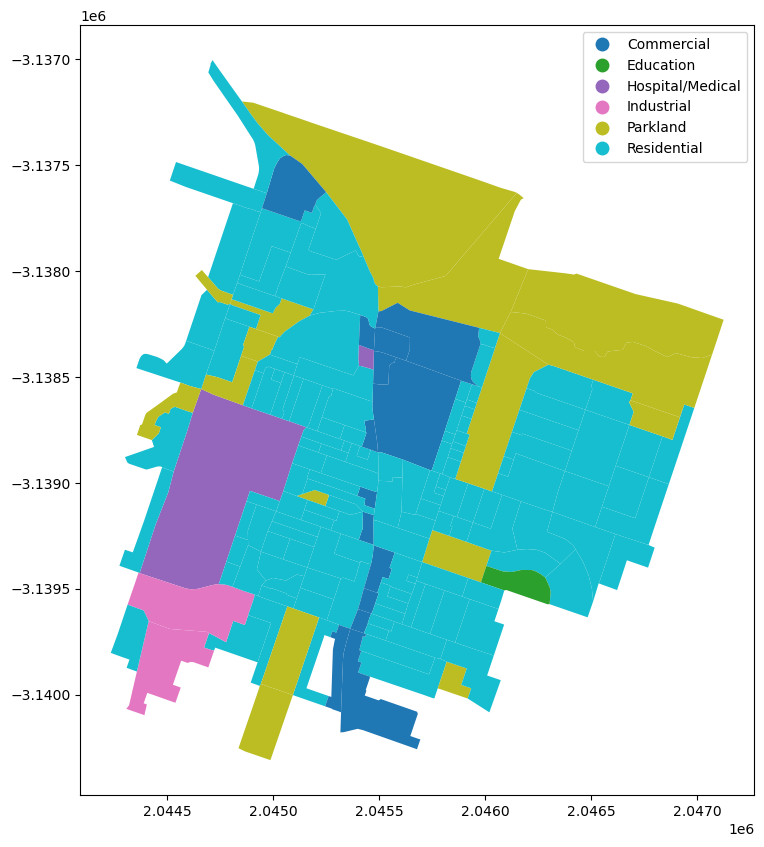

In [36]:
# Plot mesh blocks by category

gdf_mb.plot(
    column="MB_CAT21",
    legend=True,
    figsize=(15, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
)

# Step 2  Extract Data for the Analysis

## 2.1 Choose the most frequent offence for the analysis

In [37]:
off_df.value_counts('Type')

Type
Other Theft (excl. Unlawful Entry)    6394
Drug Offences                         1527
Unlawful Entry                         896
Good Order Offences                    771
Fraud                                  624
Assault                                602
Other Property Damage                  600
Traffic and Related Offences           508
Handling Stolen Goods                  309
Unlawful Use of Motor Vehicle          259
Weapons Act Offences                   184
Trespassing and Vagrancy               127
Robbery                                100
Other Offences Against the Person       94
Miscellaneous Offences                  24
Arson                                   12
Liquor (excl. Drunkenness)              12
Homicide (Murder)                        1
Other Homicide                           1
Name: count, dtype: int64

## 2.2 Hotspot map of crime incident for last 5 years

The crime data has attributes for the offence type and ABS Meshblock codes. Only *Other Theft (excl. Unlawful Entry)* offences is considered. Meshblock data is read with a spatial filter to get rows overlapping Chermside boundary.

A subset of offense data for Other Theft (excl. Unlawful Entry) only is obtained and this is summarised by count for meshblocks.

In [38]:
#  Join the offence data for counts of assaults only 

# Slice to get Other Theft (excl. Unlawful Entry) only

crime_df = off_df[off_df.Type=='Other Theft (excl. Unlawful Entry)']
# Summarise the offences by mesh block
crime_counts = crime_df.groupby('ABS Meshblock').agg({'Type':'count'})
crime_counts['Count'] = crime_counts['Type']
crime_counts.reset_index(inplace=True)

# Join the mesh block data with the offence data
gdf_mb_crime = gdf_mb.merge(crime_counts, right_on='ABS Meshblock', left_on='MB_CODE21')

# filter necessary columns to view
gdf_mb_crime[['MB_CODE21', 'MB_CAT21', 'SA2_NAME21','Count']].head()

,MB_CODE21,MB_CAT21,SA2_NAME21,Count
0,30052200000,Residential,Chermside,16
1,30052210000,Residential,Chermside,5
2,30052220000,Residential,Chermside,13
3,30052230000,Parkland,Chermside,2
4,30052240000,Residential,Chermside,11


<AxesSubplot: >

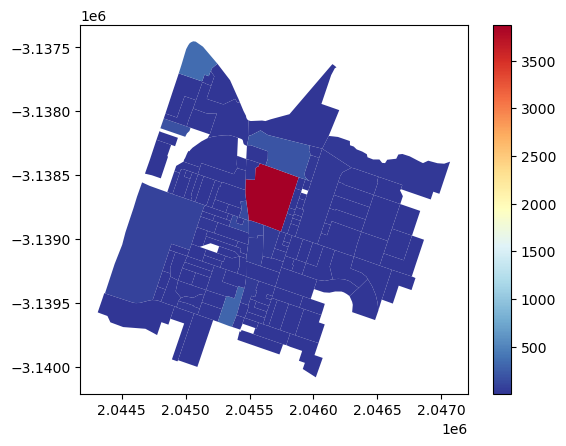

In [39]:
# To identify the land use for high crime rate
gdf_mb_crime.plot(column = 'Type', legend=True, cmap="RdYlBu_r")

# Step 3: Compute the distance between crime incident and commercial areas

In [40]:
from shapely.ops import unary_union

# To filter the land use by commercial
target_landuse = 'Commercial'
gdf_mb_lu = gdf_mb.query("MB_CAT21=='{}'".format(target_landuse))

# Combine all the commercial areas together
unioned_mb_target_lu = unary_union(gdf_mb_lu['geometry'])

# Calculate the distances
gdf_mb_crime["dist_decay"] = gdf_mb_crime.geometry.distance(unioned_mb_target_lu)

gdf_mb_crime[["MB_CAT21","Count","dist_decay"]].head()

,MB_CAT21,Count,dist_decay
0,Residential,16,238.518214
1,Residential,5,58.544616
2,Residential,13,117.853006
3,Parkland,2,136.702525
4,Residential,11,92.963008


# Step 4: Visualise the Relationship for Distance Decay

Text(0.5, 1.0, 'Distance decay Relationship for Other theft and Commercial areas in Chermside last 5 years')

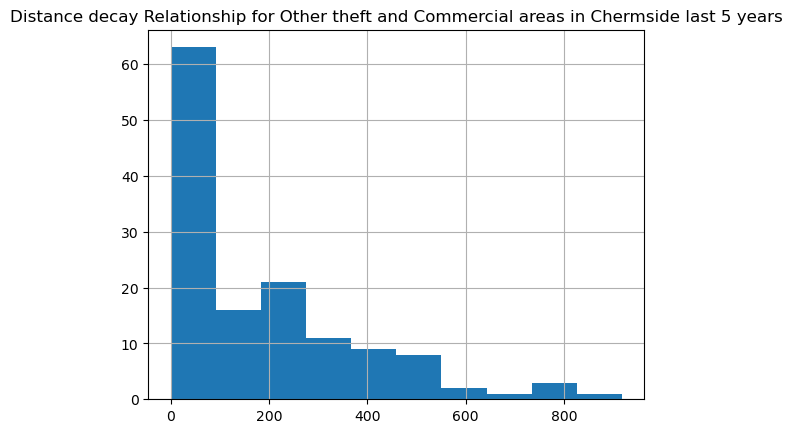

In [41]:
ax = gdf_mb_crime.dist_decay.hist()
ax.set_title('Distance decay Relationship for Other theft and Commercial areas in Chermside last 5 years')

Text(0.5, 1.0, 'Distance decay Relationship for Drug offences and Commercial areas in Chermside 2023/24')

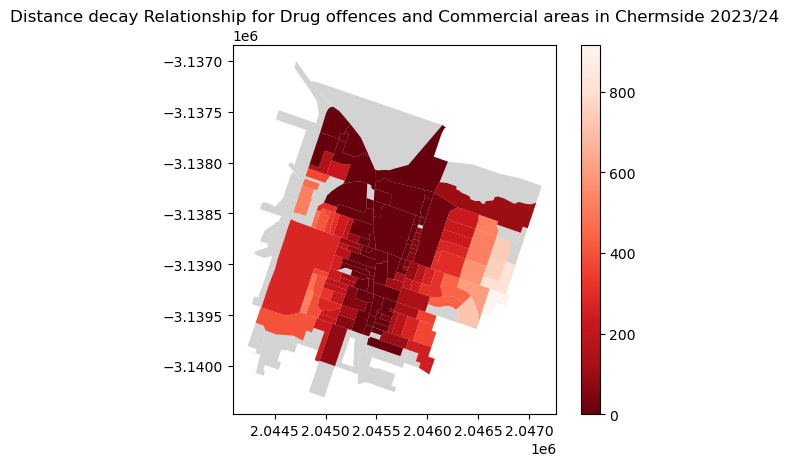

In [42]:
axplot_suburb = gdf_mb.plot(color='lightgray')
gdf_mb_crime.plot(column="dist_decay", cmap="Reds_r", legend=True, ax = axplot_suburb)
axplot_suburb.set_title('Distance decay Relationship for Drug offences and Commercial areas in Chermside 2023/24')